# Measuring MTF from Blocks in Philips PIQT and TO4

In [1]:
%matplotlib inline

from warnings import warn
    
import numpy as np
from mriqa.phantoms import phantom_mask_2d, find_phantom
from mriqa.tools import show_mosaic, all_ims
from mriqa.dcmio import fetch_series
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom as ndizoom
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
from scipy.interpolate import interp1d
from dcmfetch import fetch_series
from skimage.filters import sobel
from pydicom.dataset import Dataset

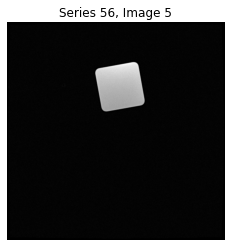

In [2]:
# PIQT: Distortion
# SE: Axial, Phase RL, 512 matrix
patid = 'PQA20181213BCH3Y'
stuid = '1'
dobjs = fetch_series(patid, stuid, sernos=[56])
show_mosaic(dobjs[4])

In [3]:
[d.Manufacturer for d in dobjs]

['SIEMENS', 'SIEMENS', 'SIEMENS', 'SIEMENS', 'SIEMENS']

Describe the position of the block in the phantom. Note we can't use this slice to get the centre of the phantom but we can use the flood slice for that. We also don't know the rotation, but we can assume it is small so we always include all the mtf block. The actual angle we can deduce by fitting straight lines to the edges.

In [4]:
PIQTMTF = {
    'Diameter': 190,
    'PD': 1.0,
    'T1': 500.0,
    'T2': 500.0,
    'Features': {
        'Blocks': [
            ((-45, -95), (90, 90)) # mm wrt isocentre?
        ]
    }
}

PIQTSNR = {
    'Diameter': 190,
    'PD': 1.0,
    'T1': 500.0,
    'T2': 500.0
}

In [5]:
from mriqa.dcmio import pix_spacing_yx
from mriqa.tools import find_phantom

snr_dobj, mtf_dobj = dobjs[2:5:2]
snr_image, mtf_image = snr_dobj.pixel_array, mtf_dobj.pixel_array
pix_dims = pix_spacing_yx(snr_dobj)
# assume square pixels
assert np.isclose(*pix_dims)

Need to get centre of phantom from uniformity section as it's difficult from just the isolated block.

In [6]:
expected_radius = PIQTSNR['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(snr_image, expected_radius=expected_radius)
print(centre_x, centre_y, radius)

264 252 204


We can assume then that the rotation is not too severe and we can place a fixed box around the square mtf block.

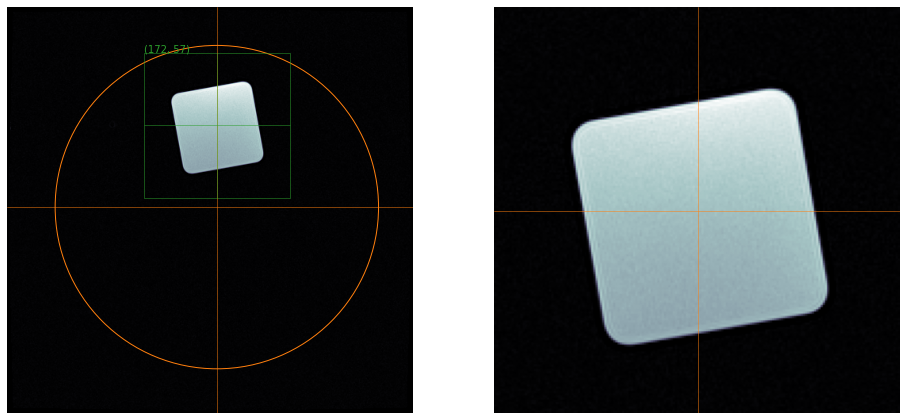

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mtf_image, cmap='bone')
axs[0].axis('off')
axs[0].grid(False)
nrows, ncols = mtf_image.shape

axs[0].axvline(centre_x, linewidth=0.5, color='C1')
axs[0].axhline(centre_y, linewidth=0.5, color='C1')
axs[0].add_artist(
    plt.Circle((centre_x, centre_y), radius, color='C1', fill=False)
)

phantom = PIQTMTF
blocks = phantom['Features']['Blocks']

(x, y), (dx, dy) = np.array(blocks[0]) / pix_dims
# are we missing an off-by-one adjustment here?
x += centre_x
y += centre_y

x = int(round(x))
y = int(round(y))
dx = int(round(dx))
dy = int(round(dy))

axs[0].text(x, y, f'({x}, {y})', color='C2')
axs[0].add_artist(
    plt.Rectangle((x, y), dx, dy, color='C2', fill=False, linewidth=0.5)
)
axs[0].vlines([x+dx/2], y, y+dy, color='C2', linewidth=0.5)
axs[0].hlines([y+dy/2], x, x+dx, color='C2', linewidth=0.5)

roi = mtf_image[y:y+dy, x:x+dx]

axs[1].imshow(roi, cmap='bone')
axs[1].axis('off')
axs[1].grid(False)
nrows, ncols = roi.shape

axs[1].axvline(ncols/2, linewidth=0.5, color='C1')
axs[1].axhline(nrows/2, linewidth=0.5, color='C1');

Once we have bounding box we can fit to edges for rotation or just a bright square and a correlation match.

Getting the rotation is a bit awkward. We could fit all the edges and take the average of the angles to the horizontal or vertical (as appropriate). Ie just add 90 degrees the angles from the two side edges. 

We would like to have a known block angle but as we can't rely on the phantom alignment and we can't internally distinguish a rotation in any other way.

Could fit a general model as before or maybe all together a bright square of variable position, size and angle with a quadratic brightness variation and gaussian edge blurring. All we wan't out is the position and angle and we can put pretty tight box constraits on all the parameters.

Note also the rounded corners that we'll need to exclude.

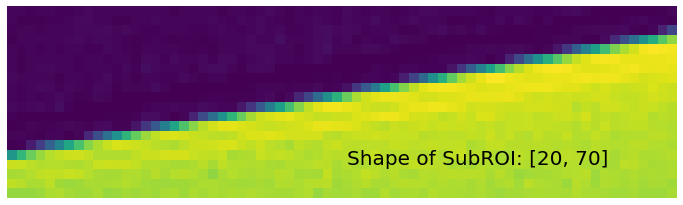

In [8]:
subroi = roi[35:55, 50:120]
plt.figure(figsize=(12, 5))
plt.imshow(subroi, cmap='viridis')
plt.text(35, 16, 'Shape of SubROI: %s' % list(subroi.shape), fontsize=20);
plt.axis('off')
plt.grid(False)

We could try a simple edge detection first to get the rough slope and offset. We'll try a few different methods.

In [9]:
from skimage.filters import roberts, sobel, scharr, prewitt
method_dict = {
    'roberts': roberts,
    'sobel':   sobel,
    'scharr':  scharr,
    'prewitt': prewitt 
}

@interact(method=method_dict)
def show_edges(method):
    plt.figure(figsize=(12, 5))
    edges = method(subroi)
    plt.imshow(subroi, cmap='viridis', alpha=0.5)
    plt.imshow(edges, alpha=0.5)
    plt.grid(None)
    plt.axis('off')
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    plt.plot(X, Y, '.', markersize=2.5)
    a, b = np.polyfit(X, Y, deg=1)
    plt.plot(X, a*X + b, linewidth=0.75)
    angle = np.degrees(np.arctan(a))
    offset = b
    plt.text(10, 10, '%s: Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees' % (method.__name__, offset, angle), fontsize=16)

interactive(children=(Dropdown(description='method', options={'roberts': <function roberts at 0x7fcc9dbb0790>,…

They all actually work pretty well - the roberts is slightly different from the others. We could use this as a starting point for a more general fit and see if it makes any difference. The general function will model the edge thickness and a quadratic gain field as well as the edge position and slope.

In [10]:
def edge_fit(roi, method=sobel):
    edges = method(roi)
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    a, b = np.polyfit(X, Y, deg=1)
    return a, b

a, b = edge_fit(subroi)
print('Angle = %0.1f degrees' % (np.degrees(np.arctan(a))))
print('Intercept = %0.1f' % b)

Angle = -10.2 degrees
Intercept = 14.9


Ah, angles are negative as coordinate origin is top-left not bottom-left. Remember to change the sign when required.

In [11]:
from scipy.special import erf, erfc
from scipy.optimize import curve_fit

def model(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # linear model of edge position
    loc = intercept + x * slope
    # complementary error function model of edge transition
    result =  gain * (i0 + (i1 - i0) * erfc((y-loc) / sigma))
    # curve_fit() needs the image flattened to 1D
    return result.ravel()

# Coordinates
X, Y = np.meshgrid(np.arange(subroi.shape[1]), np.arange(subroi.shape[0]))

# Starting Point
i0_0 = subroi[-10:, -10:].mean()
i1_0 = subroi[:10, :10].mean()

a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
sigma_0 = 1.0

#intercept_0 = 36.67
#slope_0 = -0.1895

slope_0, intercept_0 = edge_fit(subroi)

p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

# Data to fit
ydata = subroi.copy()

The 'model' image using these initial parameters.

Starting parameters: [1997.17, 33.53, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 14.942493415276559, -0.1803450776806505]


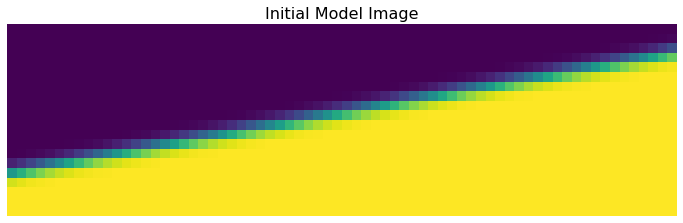

In [12]:
print('Starting parameters:', p0)

assert X.shape == Y.shape == subroi.shape
plt.figure(figsize=(12, 5))
plt.imshow(model((X, Y), *p0).reshape(ydata.shape), cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image', fontsize=16);

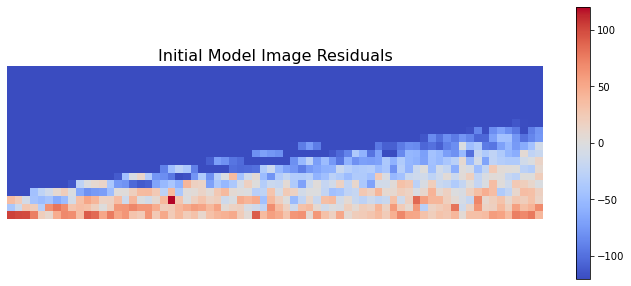

In [13]:
fig = plt.figure(figsize=(12, 5))
residuals = model((X, Y), *p0).reshape(ydata.shape)-ydata
img = plt.imshow(residuals, cmap='coolwarm', vmin=-residuals.max(), vmax=residuals.max())
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image Residuals', fontsize=16)
fig.colorbar(img);

Now we'll fit the model using scipy `curve_fit`.

In [14]:
popt, pcov = curve_fit(model, xdata=(X, Y), ydata=ydata.ravel(), p0=p0)
i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt
print('Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees, Vertical Edge Sigma = %0.2f pixels' % (intercept, np.degrees(np.arctan(slope)), sigma))

Offset = 14.95 pixels; Angle (to Horizontal) = -10.23 degrees, Vertical Edge Sigma = 0.62 pixels


This is the new model image.

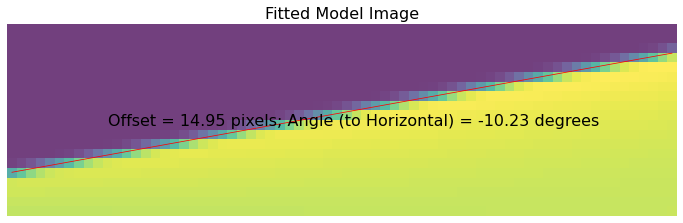

Fitted parameters:
1968.60425, 995.02385, 1.45856, -0.00378, -0.03657, 0.00000, 0.00061, 0.00021, 0.61948, 14.94817, -0.18048


In [15]:
plt.figure(figsize=(12, 5))
plt.imshow(model((X, Y), *popt).reshape(ydata.shape), cmap='viridis', alpha=0.75)
plt.axis('off')
plt.grid(False)
plt.plot(X[0], slope*X[0] + intercept, linewidth=0.75, color='red')

angle = np.degrees(np.arctan(slope))
offset = intercept
plt.text(10, 10, 'Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees' % (offset, angle), fontsize=16)
plt.title('Fitted Model Image', fontsize=16)
plt.show();

print('Fitted parameters:')
print(', '.join(['%0.5f' % p for p in popt]))

And the residuals now are much smaller - the fit seems pretty good.

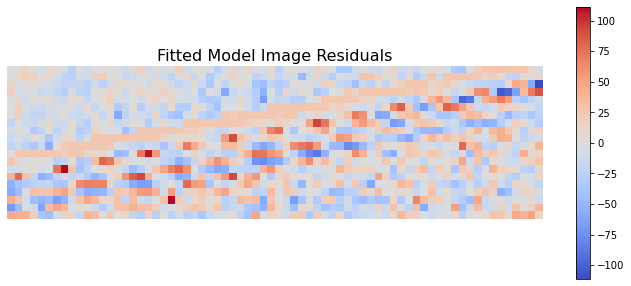

In [16]:
fig = plt.figure(figsize=(12, 5))
residuals = model((X, Y), *popt).reshape(ydata.shape)-ydata
img = plt.imshow(residuals, cmap='coolwarm', vmin=-residuals.max(), vmax=residuals.max())
plt.axis('off')
plt.grid(False)
plt.title('Fitted Model Image Residuals', fontsize=16)
fig.colorbar(img);

Now we have an accurate angle and intercept we need to do some sort of interpolation with offset. We'll evaluate the shifted rows on a subpixel grid. First we'll attempt a correction for non-uniformity using the fitted bias field.

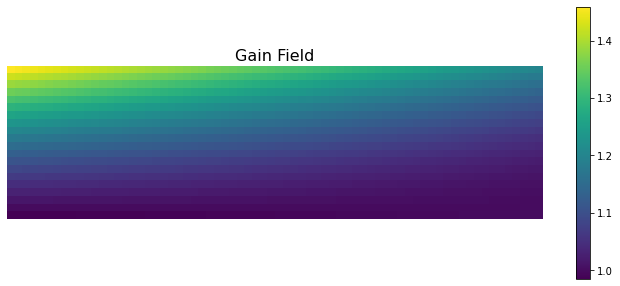

In [17]:
# quadratic model of bias field
gain = a + b*X + c*Y + d * X**2 + e * Y**2 + f * X*Y

fig = plt.figure(figsize=(12, 5))
img = plt.imshow(gain, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Gain Field', fontsize=16)
fig.colorbar(img);

### Intensity Normalization

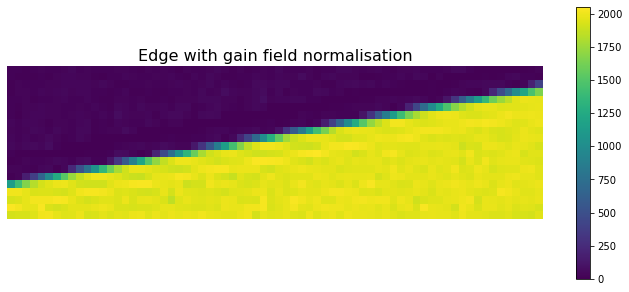

In [18]:
ydata_norm = ydata / gain
fig = plt.figure(figsize=(12, 5))
img = plt.imshow(ydata_norm, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge with gain field normalisation', fontsize=16)
fig.colorbar(img);

### Intensities Ordered by Distance from Edge
Have a look at the pixels, just by plotting their value against their distance from the nominal edge, horizontally, vertically and perpendicularly. I'm not clear what the geometric scaling factor would be for the perpendicular distance.

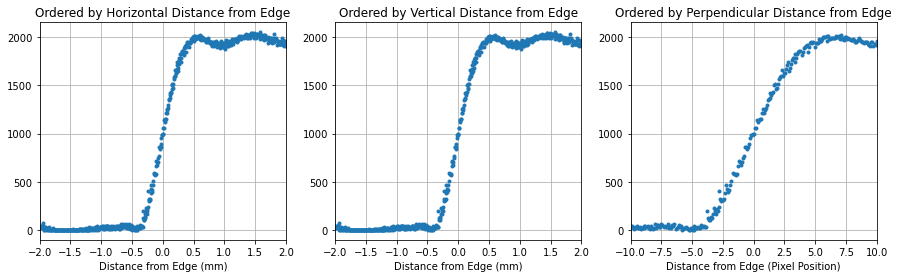

In [19]:
nrows, ncols = ydata_norm.shape

x_shifts_at_y = (np.arange(nrows) - intercept) / slope
X_shifted = (X - x_shifts_at_y[Y]).ravel()
sort_order_row = np.argsort(X_shifted)

y_shifts_at_x = np.arange(ncols) * slope + intercept
Y_shifted = (Y - y_shifts_at_x[X]).ravel()
sort_order_col = np.argsort(Y_shifted)

Perp_shifted = np.hypot(X_shifted, Y_shifted) * np.sign(X_shifted)
sort_order_perp = np.argsort(Perp_shifted)

pixvals = ydata_norm.ravel()

proj_factor_row = np.abs(np.sin(np.arctan(slope)))
proj_factor_col = np.abs(np.cos(np.arctan(slope)))
effective_pixel_size_row = pix_dims[1] * proj_factor_row
effective_pixel_size_col = pix_dims[0] * proj_factor_col

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(X_shifted[sort_order_row] * effective_pixel_size_row, pixvals[sort_order_row], '.')
axs[0].set_xlim(-2, 2)
axs[0].grid(True)
axs[0].set_xlabel('Distance from Edge (mm)')
axs[0].set_title('Ordered by Horizontal Distance from Edge')
axs[1].plot(Y_shifted[sort_order_col]  * effective_pixel_size_col, pixvals[sort_order_col], '.')
axs[1].set_xlim(-2, 2)
axs[1].grid(True)
axs[1].set_xlabel('Distance from Edge (mm)')
axs[1].set_title('Ordered by Vertical Distance from Edge')
axs[2].plot(Perp_shifted[sort_order_perp], pixvals[sort_order_perp], '.')
axs[2].set_xlim(-10, 10)
axs[2].grid(True)
axs[2].set_xlabel('Distance from Edge (Pixel Position)')
axs[2].set_title('Ordered by Perpendicular Distance from Edge');

Odd. Vertical and horizontal seem to be exactly the same. Have I argued round in a circle here? The width of the edge plotted like this seems to be just about the pixel size anyway - so we really don't seem to have any sub pixel information.

Maybe we could fit these points with a spline or low order polynomial - we really want them on a regular grid and smooth enough to differentiate.

We could try Gaussian Process Regression:
 - http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
 - https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
 - http://scikit-learn.org/stable/modules/gaussian_process.html
 - https://stackoverflow.com/questions/24978052/interpolation-over-regular-grid-in-python
 - https://en.wikipedia.org/wiki/Kriging

Alternatively, we could use lowess and interpolation.

Note also that we are dealing with unsigned images. It rather looks as if negative values are clipped rather than inverted. This makes the edge response asymmetric.


### Lowess Smoothing and Regridding
OK, Let's try a lowess, followed by interpolation onto a grid

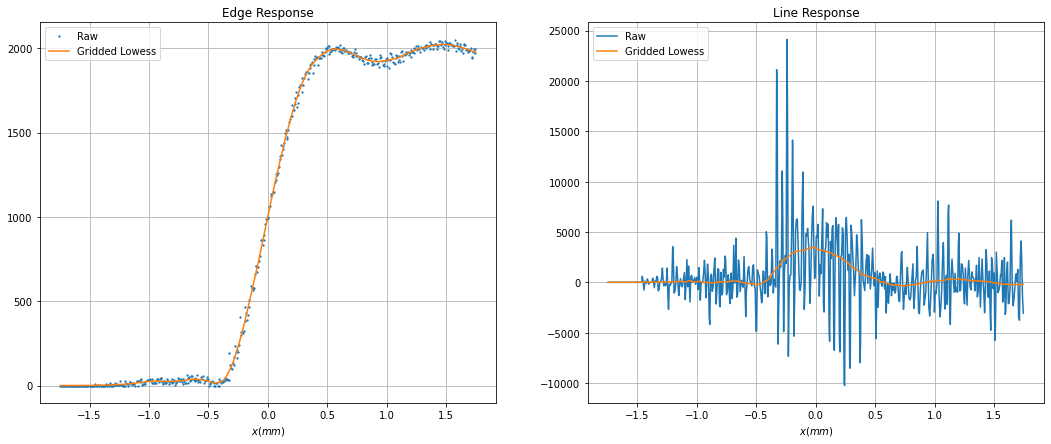

In [20]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
lowess = sm.nonparametric.lowess

locns_mm = X_shifted[sort_order_row] * effective_pixel_size_row
vals_at_locns = pixvals[sort_order_row]

# Trim down to +/- 1.75 mm
vals_at_locns = vals_at_locns[(-1.75 < locns_mm) & ((locns_mm < 1.75))]
locns_mm = locns_mm[(-1.75 < locns_mm) & ((locns_mm < 1.75))]

x = locns_mm
y = vals_at_locns - vals_at_locns.mean()

# Lowess fit on irregular grid
assert(list(x) == sorted(x))
w = lowess(y, x, frac=0.05, return_sorted=False)

# Interpolate onto regular grid
f = interp1d(x, w, kind='cubic')
x_grid = np.linspace(x.min(), x.max(), 512)
dx_grid = x_grid[1]-x_grid[0]
w_grid = f(x_grid)

_, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].plot(x, vals_at_locns, '.', markersize=2.5, label='Raw')
axs[0].plot(x_grid, w_grid+vals_at_locns.mean(), label='Gridded Lowess')

axs[0].set_xlabel('$x (mm)$')
axs[0].legend(loc='upper left')
axs[0].grid(True)
axs[0].set_title('Edge Response')

axs[1].plot(x, np.gradient(y, x), label='Raw')
axs[1].plot(x_grid, np.gradient(w_grid, dx_grid), label='Gridded Lowess')
axs[1].set_xlabel('$x (mm)$')
axs[1].legend(loc='upper left')
axs[1].set_title('Line Response')

axs[1].grid(True)

### Line response and MTF

513
Real Pixel Size: 0.48828125 mm
Projected Pixel Size: 0.0867256258887577 mm
Effective Pixel Size: 0.0068301085850557275 mm
Line Response Length: 512


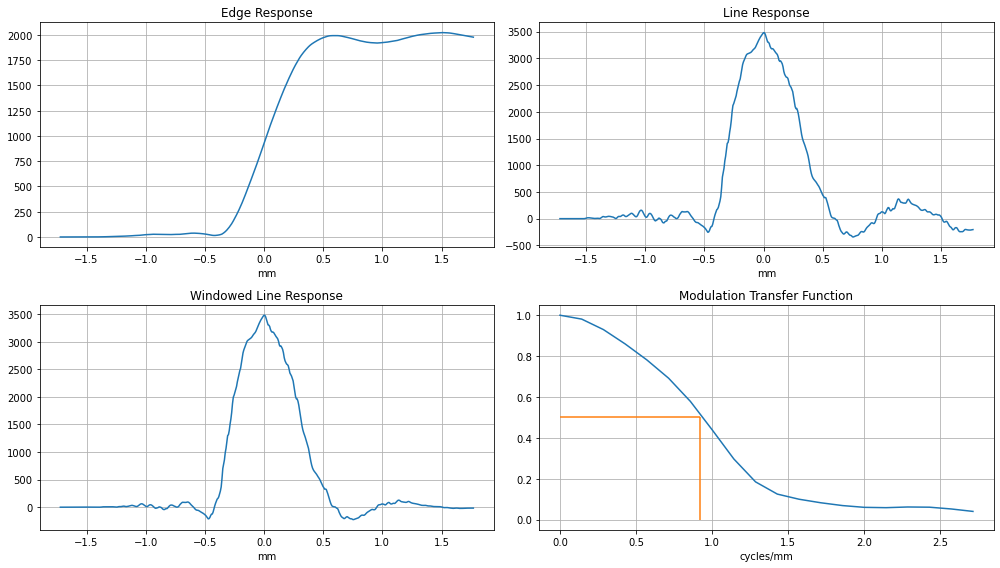

In [21]:
from scipy.signal import hamming
from numpy.fft import rfft, fftshift, fft

edge_response = w_grid + vals_at_locns.mean()
line_response = np.gradient(edge_response, dx_grid)
windowed_line_response = line_response * hamming(len(line_response))

proj_factor = np.abs(np.sin(np.arctan(slope)))

effective_pixel_size = dx_grid
#effective_pixel_size = pix_dims[1] / k * proj_factor

pk_ind = np.argmax(line_response)

npoints = len(windowed_line_response)

# Normalized to maximum at DC
mtf = np.abs(rfft(np.pad(windowed_line_response, npoints//2, mode='constant')))
assert mtf.argmax() == 0
mtf /= mtf[0]

# Check this - we are working in mm
x_mtf = np.arange(2*len(mtf)) / len(windowed_line_response) / effective_pixel_size / 2

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.ravel()

x_axis_edge = (np.arange(len(edge_response)) - pk_ind) * effective_pixel_size
axs[0].plot(x_axis_edge, edge_response)
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')
axs[0].grid(True)

x_axis_line = (np.arange(len(line_response)) - pk_ind) * effective_pixel_size
axs[1].plot(x_axis_line, line_response)
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm')
axs[1].grid(True);

axs[2].plot(x_axis_line, windowed_line_response)
axs[2].set_title('Windowed Line Response')
axs[2].set_xlabel('mm')
axs[2].grid(True)

print(len(mtf))
axs[3].plot(x_mtf[:20], mtf[:20])
axs[3].set_title('Modulation Transfer Function')
axs[3].set_xlabel('cycles/mm')
axs[3].grid(True)
# need to interpolate to get 50% point as too few points
x_mtf_interp = np.linspace(x_mtf[0], x_mtf[20], 100)
mtf_interp = interp1d(x_mtf[:21], mtf[:21])(x_mtf_interp)
halfmax = x_mtf_interp[(abs(mtf_interp - 0.5)).argmin()]
axs[3].vlines(halfmax, 0, 0.5, color='C1')
axs[3].hlines(0.5, 0, halfmax, color='C1')


plt.tight_layout()

print('Real Pixel Size:', pix_dims[1], 'mm')
print('Projected Pixel Size:', pix_dims[1] * proj_factor, 'mm')
print('Effective Pixel Size:', effective_pixel_size, 'mm')
print('Line Response Length:', len(line_response))

Still TODO:
 - Check definition of parameters from MTF
 - FWHM of line response
 - Identify 4 edges from general region (peaks in Hough Line Transform?)
 - Rule for trimming line segments
 - Combination of individual curves - how to register? around peak in line response?
 - Do we separate out (near) horizonatal and vertical edges
 - Check sensitivity of paramaters
 - Can we determine inclinations jointly?
   - Could fit whole block with model but what about the rounded corners?

### Find the Block and Edges

We can do a hough line transform to get the main faces of tehe blocks.
Then do intersections with adjacent lines to get a line *segment* 

From the line *segment* between the two intersections we then want to get the coordinates of a rectangular ROI:

- For the *horizontal* edges we can do this as follows:
 - ylimits are a bit below ymin and a bit above ymax, xlimits are bit above xmin and a bit below xmax
- For the *vertical* edges
 - ylimits are a bit above ymin and a bit below ymax, xlimits are bit below xmin and a bit above xmax
where growing, the margin is quite large, where shrinking, it's onl a little (say 10% of the segment length)



line1: 79.70338983050847 58.0
line2: -10.296610169491526 126.0
line3: -10.296610169491526 23.0
line4: 79.70338983050847 161.0
Intersections: [134.33799973  34.54420109] [32.9967514  52.95483356]
centre: [83.66737557 43.74951732]
103.00000000000001


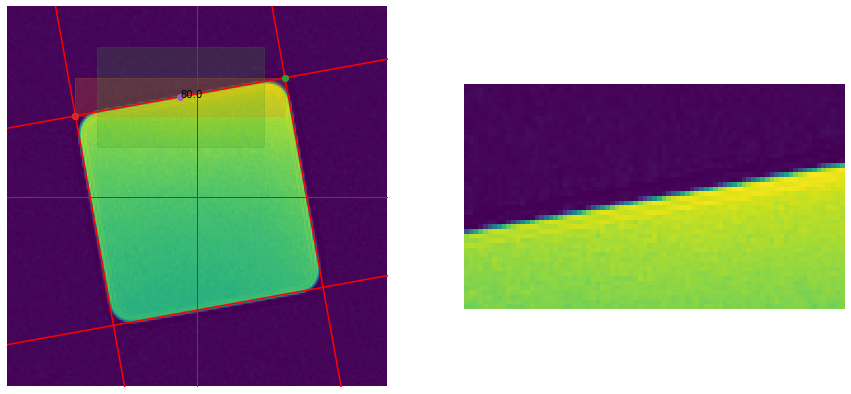

In [22]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import binary_erosion, binary_dilation, disk
from matplotlib.patches import Rectangle

def intersection(line1, line2):
    """
    Intersection of two lines in Hesse normal form.
    See https://stackoverflow.com/a/383527/5087436
    """
    theta1, rho1 = line1
    theta2, rho2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    #b = np.array([[rho1], [rho2]])
    b = [rho1, rho2]

    x0, y0 = np.linalg.solve(A, b)
    #x0, y0 = int(np.round(x0)), int(np.round(y0))
    return (x0, y0)


# We may want to adjust first to place the block in the centre of the FOV ...

# Rough edges with threshold and morphology and then Canny within that
# May want to use more robust threshold, especially as some intensity variation
mask = roi > roi.mean()
mask = binary_dilation(mask, disk(3)) & ~binary_erosion(mask, disk(3))
edges = mask & canny(roi/roi.mean(), sigma=3) & mask

# Hough Line Tranform
tested_angles = np.r_[
    np.linspace(-np.pi / 8, np.pi / 8, 60),
    np.linspace(3*np.pi / 8, 5*np.pi / 8, 60)
                      
]
h, theta, d = hough_line(edges, theta=tested_angles)

# Pick 4 best lines
peaks = hough_line_peaks(h, theta, d)
x0_x1 = np.array([0, roi.shape[1]])
angles, dists = peaks[1][:4], peaks[2][:4]

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.imshow(roi)
for angle, dist in zip(angles, dists):
    y0_y1 = (dist - x0_x1 * np.cos(angle)) / np.sin(angle)
    ax.plot(x0_x1, y0_y1, '-r')

ax.set_xlim(x0_x1)
ax.set_ylim((roi.shape[0], 0))
ax.axis(False)
ax.axhline(roi.shape[0]/2, color='red', linewidth=1)
ax.axvline(roi.shape[1]/2, color='red', linewidth=1)

line1 = angles[0], dists[0]
line2 = angles[1], dists[1]
line3 = angles[2], dists[2]
line4 = angles[3], dists[3]

print('line1:', np.degrees(angles[0]), dists[0])
print('line2:', np.degrees(angles[1]), dists[1])
print('line3:', np.degrees(angles[2]), dists[2])
print('line4:', np.degrees(angles[3]), dists[3])

ax.plot(*intersection(line1, line2), 'o')
ax.plot(*intersection(line1, line3), 'o')

p1 = np.array(intersection(line1, line2))
p2 = np.array(intersection(line1, line3))
# centre of line segment
p0 = (p2 + p1) /2

print('Intersections:', p1, p2)
print('centre:', p0)
        
ax.plot(*p1, 'o')
ax.plot(*p2, 'o')
ax.plot(*p0, 'o')
ax.text(*p0, np.round(np.degrees(angles[0])))
line_segment_length = np.hypot(*(p1 - p2))

print(line_segment_length)

ps = np.array([p1, p2])

bbox = np.asarray([
    np.min(ps, axis=0),
    np.max(ps, axis=0)
])
ax.add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='C1'
    )
)  

# this will depend on pixel size - we needsomething phantom related
# this seems to be not quite central - correct for angle?
bbox[0] -= (-line_segment_length/10, 15)
bbox[1] += (-line_segment_length/10, 15)

ax.add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='C2'
    )
)
bbox = np.round(bbox).astype(int)

ax = axs[1]

subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
ax.imshow(subroi)
ax.axis(False);
# from the offsets we should be able to put boxes round the edges, the intersections tell as the limits of the lint segments
# then take a bit off for the rounded edges.

OK, we just need to sort out the order of the lines and edges.

for each line:
    decide whether it is horizontal or vertical
    find two lines of opposite type
    for horizontal lines select horiz rectangle
    for vertical lines select vertical rectangle and transpose
    if brightness decreasing with y flip ud

Then we'll have four equivalent edges - alternatively keep horiz and vert separate - OK do that initially

In [23]:
def get_mtf_edges(roi):
    def centre_angle(roi, theta, dist):
        """
        Angle around image centre to sort edges by
        """
        theta = np.pi/2 - theta
        if dist > np.hypot(*np.array(roi.shape) / 2):
            theta += np.pi
        return np.mod(theta, 2*np.pi)

    mask = roi > roi.mean()
    mask = binary_dilation(mask, disk(3)) & ~binary_erosion(mask, disk(3))
    edges = mask & canny(roi/roi.mean(), sigma=3) & mask

    # Hough Line Tranform
    tested_angles = np.r_[
        np.linspace(-np.pi / 8, np.pi / 8, 60),
        np.linspace(3*np.pi / 8, 5*np.pi / 8, 60)

    ]
    h, theta, d = hough_line(edges, theta=tested_angles)

    # Pick 4 best lines
    peaks = hough_line_peaks(h, theta, d)
    x0_x1 = np.array([0, roi.shape[1]])
    
    angles, dists = peaks[1][:4], peaks[2][:4]

    # Sort around centre of block
    angles, dists = zip(*sorted(
        zip(angles, dists),
        key=lambda pair: centre_angle(roi, pair[0], pair[1])
    ))

    return angles, dists

In [24]:
def get_subrois(roi, angles, dists):

    def extract_bbox(line1, line2, line3):
        p1 = np.array(intersection(line1, line2))
        p2 = np.array(intersection(line1, line3))
        line_segment_length = np.hypot(*(p1 - p2))
        print(line_segment_length)
        ps = np.array([p1, p2])

        return np.array([
            np.min(ps, axis=0),
            np.max(ps, axis=0)
        ])

    ny, nx = roi.shape
    print('All lines:', list(zip(angles, dists)))
    # nb hough angle defined such that 0 is vertical 90 is horizontal
    horiz_angles, horiz_dists = zip(*[(angle, dist) for angle, dist in zip(angles, dists) if abs(np.degrees(angle)) > 45])
    print('Horizontal lines:', list(zip(horiz_angles, horiz_dists)))

    vert_angles, vert_dists = zip(*[(angle, dist) for angle, dist in zip(angles, dists) if abs(np.degrees(angle)) <= 45])
    print('Vertical lines:', list(zip(vert_angles, vert_dists)))

    #edges = sort(zip(angles, dists), key=lambda x: abs(x[0]), x[1])
    #edges = {k, v for k, v in zip(['Left', 'Right', 'Top', 'Bottom'], edges)}

    #for k, (angle, dist) in edges.items():
        
    subrois = {}

    # horizontal edges
    for horiz_angle, horiz_dist in zip(horiz_angles, horiz_dists):
        line1 = horiz_angle, horiz_dist
        line2 = vert_angles[0], vert_dists[0]
        line3 = vert_angles[1], vert_dists[1]

        bbox = extract_bbox(line1, line2, line3)
        print(f'Horiz BBox: box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')

        bbox[0] -= (-line_segment_length/10, 15)
        bbox[1] += (-line_segment_length/10, 15)
        print(f'Line Segment Length: {line_segment_length}')
        print(f'Horiz BBox (Adjusted): box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')

        bbox = np.round(bbox).astype(int)
        print(f'Horiz BBox (Rounded): box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')
        
        bbox = np.clip(bbox, 0, None)
        bbox[1][0] = np.clip(bbox[1][0], None, nx-1)
        bbox[1][1] = np.clip(bbox[1][1], None, ny-1)

        print(f'Horiz BBox (Clipped): box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')

        subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        print('Subroi shape:', subroi.shape)
        profile = subroi.sum(axis=1)
        print('Profile length:', len(profile))
        if profile[-1] > profile[0]:
            subrois['Top'] = subroi
        else:
            subrois['Bottom'] = np.rot90(subroi, 2)
    
    # vertical edges
    for vert_angle, vert_dist in zip(vert_angles, vert_dists):
        line1 = vert_angle, vert_dist
        line2 = horiz_angles[0], horiz_dists[0]
        line3 = horiz_angles[1], horiz_dists[1]

        bbox = extract_bbox(line1, line2, line3)
        print(f'Vert BBox: box={bbox}, width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        
        # shrink along edge and grow perpendicular
        bbox[0] += (-line_segment_length/10, 15)
        bbox[1] -= (-line_segment_length/10, 15)
        print(f'Line Segment Length: {line_segment_length}')
        print(f'Vert BBox (Adjusted): box={bbox}, width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')

        bbox = np.round(bbox).astype(int)
        print(f'Vert BBox (Rounded): box={bbox}, width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')

        bbox = np.clip(bbox, 0, None)
        bbox[1][0] = np.clip(bbox[1][0], None, nx-1)
        bbox[1][1] = np.clip(bbox[1][1], None, ny-1)

        subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        
        print('Subroi shape:', subroi.shape)
        profile = subroi.sum(axis=0)
        print('Profile length:', len(profile))
        if profile[-1] > profile[0]:
            subrois['Right'] = np.rot90(subroi, 3)
        else:
            subrois['Left'] = np.rot90(subroi, 1)

    return subrois

All lines: [(1.391086577542938, 58.0), (-0.1797097492519585, 126.0), (-0.1797097492519585, 23.0), (1.391086577542938, 161.0)]
Horizontal lines: [(1.391086577542938, 58.0), (1.391086577542938, 161.0)]
Vertical lines: [(-0.1797097492519585, 126.0), (-0.1797097492519585, 23.0)]
103.00000000000001
Horiz BBox: box=[[ 32.9967514   34.54420109]
 [134.33799973  52.95483356]], height=18.410632465645342, width=101.34124832571842
Line Segment Length: 103.00000000000001
Horiz BBox (Adjusted): box=[[ 43.2967514   19.54420109]
 [124.03799973  67.95483356]], height=48.41063246564535, width=80.74124832571842
Horiz BBox (Rounded): box=[[ 43  20]
 [124  68]], height=48, width=81
Horiz BBox (Clipped): box=[[ 43  20]
 [124  68]], height=48, width=81
Subroi shape: (48, 81)
Profile length: 48
102.99999999999999
Horiz BBox: box=[[ 51.40738387 135.88544942]
 [152.74863219 154.29608188]], height=18.410632465645335, width=101.3412483257184
Line Segment Length: 103.00000000000001
Horiz BBox (Adjusted): box=[[ 61

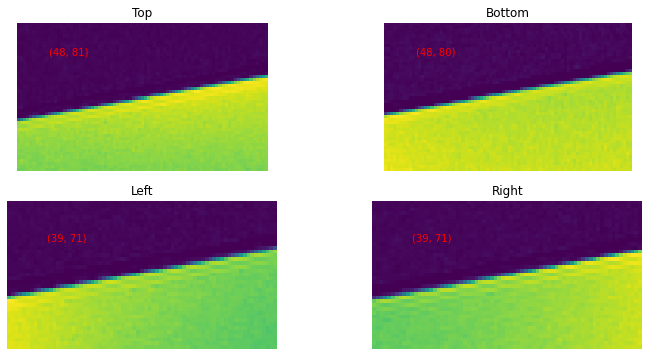

In [25]:
subrois = get_subrois(roi, angles, dists)

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for ax, (name, subroi) in zip(axs.flat, subrois.items()):
    ax.imshow(subroi)
    ax.set_title(name)
    ax.text(10, 10, f'{subroi.shape}', color='r')
    ax.axis('off')

In [26]:
from enum import Enum, auto
class Orientation(Enum):
    VERTICAL = auto()
    HORIZONTAL = auto()


def edge_fit(roi, method=sobel):
    edges = method(roi)
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    slope, intercept = np.polyfit(X, Y, deg=1)
    return slope, intercept


def model(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # linear model of edge position
    loc = intercept + x * slope
    # complementary error function model of edge transition (odd; erfc is falling)
    result =  gain * (i0 + (i1 - i0) * erfc((y-loc) / sigma))
    # curve_fit() needs the image flattened to 1D
    return result.ravel()


def fit_model(roi, model):
    # Coordinates
    X, Y = np.meshgrid(np.arange(roi.shape[1]), np.arange(roi.shape[0]))

    # Starting Point assume bottom right and top left representative
    # of background and foreground (is this the right way round? - seems back to front)
    i0_0 = roi[-10:, -10:].mean() 
    i1_0 = roi[:10, :10].mean()
    #print('erf initial:', i0_0, i1_0)
    a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
    sigma_0 = 1.0

    slope_0, intercept_0 = edge_fit(roi)

    p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

    # Data to fit
    popt, pcov = curve_fit(model, xdata=(X, Y), ydata=roi.flatten(), p0=p0)
    i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt

    gain_field = a + b*X + c*Y + d * X**2 + e * Y**2 + f * X*Y
    return slope, intercept, gain_field


def edge_profile_from_roi(roi, model=model, orientation=Orientation.HORIZONTAL):
    """
    Return irregularly sampled edge response from ROI in image.
    
    Assumes the edge appears approximately horizontal in ROI, rising left to right an bright at the bottom.
    
    """
    X, Y = np.meshgrid(np.arange(roi.shape[1]), np.arange(roi.shape[0]))
    nrows, ncols = roi.shape
    slope, intercept, gain_field = fit_model(roi.astype(float), model)
    # normalise and flatten
    pixvals = (roi / gain_field).ravel()
    
    # Try and arange to go across the edge ..
    if orientation is Orientation.VERTICAL:
        y_shifts_at_x = np.arange(ncols) * slope + intercept
        Y_shifted = (Y - y_shifts_at_x[X]).ravel()
        sort_order_col = np.argsort(Y_shifted)
        proj_factor_col = np.abs(np.cos(np.arctan(slope)))
        effective_pixel_size_col = pix_dims[0] * proj_factor_col    
        locns_mm, vals_at_locns = Y_shifted[sort_order_col]  * effective_pixel_size_col, pixvals[sort_order_col]
    elif orientation is Orientation.HORIZONTAL:
        x_shifts_at_y = (np.arange(nrows) - intercept) / slope
        X_shifted = (X - x_shifts_at_y[Y]).ravel()
        sort_order_row = np.argsort(X_shifted)
        proj_factor_row = np.abs(np.sin(np.arctan(slope)))
        effective_pixel_size_row = pix_dims[1] * proj_factor_row
        locns_mm, vals_at_locns = X_shifted[sort_order_row] * effective_pixel_size_row, pixvals[sort_order_row]
    else:
        raise ValueError('Illegal value for orientation')

    # Normalise to unit range; curve is rising from minumum at start
    npoints = len(vals_at_locns)
    lower = vals_at_locns[:npoints//4].mean()
    upper = vals_at_locns[3*npoints//4:].mean()
    return locns_mm, (vals_at_locns - lower) / (upper - lower)


def lowess_regrid(locns_mm, vals_at_locns):
    # Trim down to +/- 1.75 mm (arbitrary?)
    vals_at_locns = vals_at_locns[(-1.75 < locns_mm) & ((locns_mm < 1.75))]
    locns_mm = locns_mm[(-1.75 < locns_mm) & ((locns_mm < 1.75))]

    x = locns_mm
    y = vals_at_locns - vals_at_locns.mean()

    # Lowess fit on irregular grid
    assert(list(x) == sorted(x))
    w = lowess(y, x, frac=0.05, return_sorted=False)

    # Interpolate onto regular grid
    f = interp1d(x, w, kind='cubic')
    x_grid = np.linspace(x.min(), x.max(), 512)
    w_grid = f(x_grid)
    return x_grid, w_grid + vals_at_locns.mean()


def line_response_from_esf(locns_mm, vals_at_locns):
    grid_spacing = locns_mm[1]-locns_mm[0]
    lsf = np.gradient(vals_at_locns, grid_spacing)
    return lsf * hamming(len(lsf))


def msf_from_lsf(locns_mm, windowed_lsf):
    npoints = len(windowed_lsf)

    mtf = np.abs(rfft(np.pad(windowed_lsf, npoints//2, mode='constant')))
    if mtf.argmax() != 0:
        warn('MTF maximum is not at zero')
    mtf /= mtf[0]

    effective_pixel_size = locns_mm[1] - locns_mm[0]
    
    # Check this - we are working in mm
    x_mtf = np.arange(2*len(mtf)) / len(windowed_lsf) / effective_pixel_size / 2
    
    # Normalized to maximum at DC
    return x_mtf, mtf / mtf[0]
    

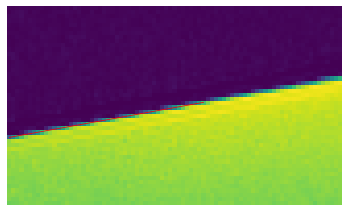

In [27]:
subroi = subrois['Top']
ny, nx = subroi.shape
plt.imshow(subroi)
slope, intercept, gain = fit_model(subroi, model)
X, Y = np.meshgrid(np.arange(ny), np.arange(nx))
plt.plot(X[0], slope*X[0] + intercept, linewidth=0.75, color='red')
plt.axis('off');

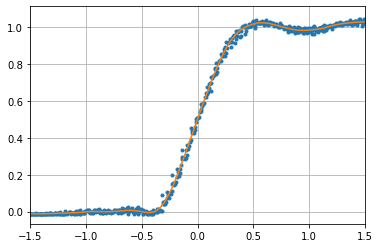

In [28]:
subroi = subrois['Top']
locns_mm, vals_at_locns = edge_profile_from_roi(subroi)
plt.plot(locns_mm, vals_at_locns, '.')
locns_mm_grid, vals_at_locns_grid = lowess_regrid(locns_mm, vals_at_locns)
plt.plot(locns_mm_grid, vals_at_locns_grid)
plt.xlim(-1.5, 1.5)
plt.grid(True);

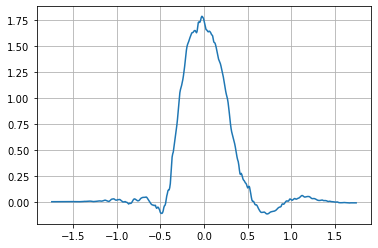

In [29]:
line_response_from_esf(locns_mm_grid, vals_at_locns_grid)

grid_spacing = locns_mm_grid[1]-locns_mm_grid[0]
windowed_lsf = line_response_from_esf(locns_mm_grid, vals_at_locns_grid)
plt.plot(locns_mm_grid, windowed_lsf)
plt.grid(True);

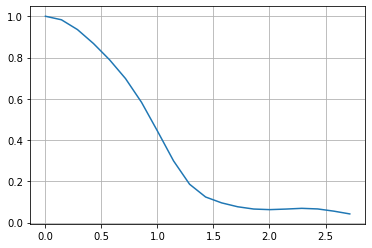

In [30]:
x_mtf, mtf = msf_from_lsf(locns_mm_grid, windowed_lsf)
plt.plot(x_mtf[:20], mtf[:20])
plt.grid(True);

In [31]:
def edge_analysis(roi, model=model):
    x_mm, esf = edge_profile_from_roi(roi, model=model)
    x_mm_grid, esf_grid = lowess_regrid(x_mm, esf)
    windowed_lsf = line_response_from_esf(x_mm_grid, esf_grid)
    x_mtf, mtf = msf_from_lsf(x_mm_grid, windowed_lsf)
    return x_mm, esf, x_mm_grid, esf_grid, windowed_lsf, x_mtf, mtf

In [32]:
def report_edge(roi, name, model=model):
    x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(roi, model=model)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.ravel()
    
    axs[0].imshow(roi)
    axs[0].axis('off')
    axs[0].set_title(name)

    axs[1].plot(x_mm, esf, '.')
    axs[1].plot(x_mm_grid, esf_grid)    
    axs[1].set_xlim(x_mm_grid[0], x_mm_grid[-1])
    axs[1].grid(True)
    axs[1].set_xlabel('mm')
    axs[1].set_title('Fitted Edge Spread Function')
    
    axs[2].plot(x_mm_grid, windowed_lsf)
    axs[2].grid(True)
    axs[2].set_xlabel('mm')
    axs[2].set_title('Windowed Line Spread Function')
    
    axs[3].plot(x_mtf[:20], mtf[:20])
    axs[3].grid(True)
    axs[3].set_xlabel('Spatial Frequency (cycles per mm)')
    axs[3].set_title('Modulation Transfer Function')

    return x_mm_grid, esf_grid, lsf, x_mtf, mtf

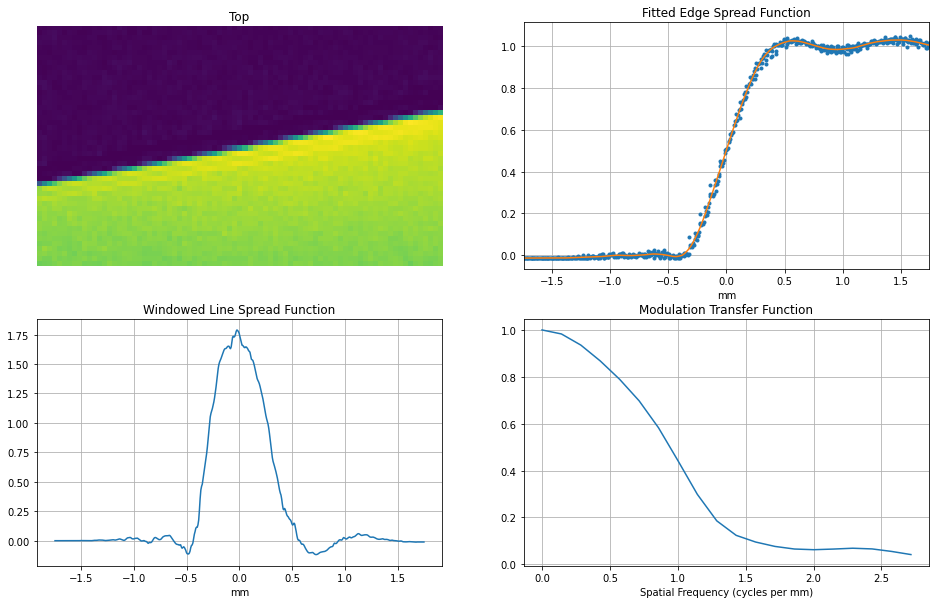

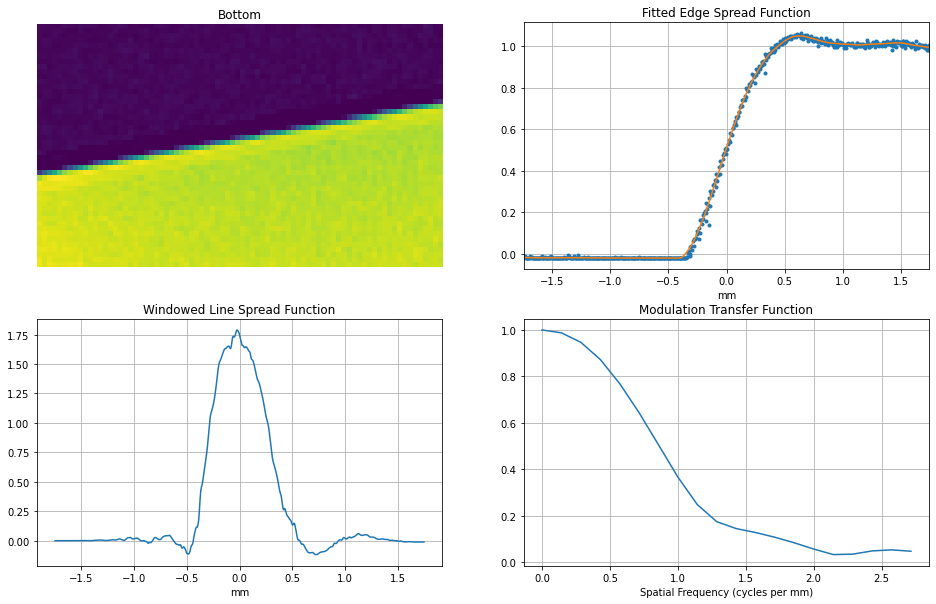

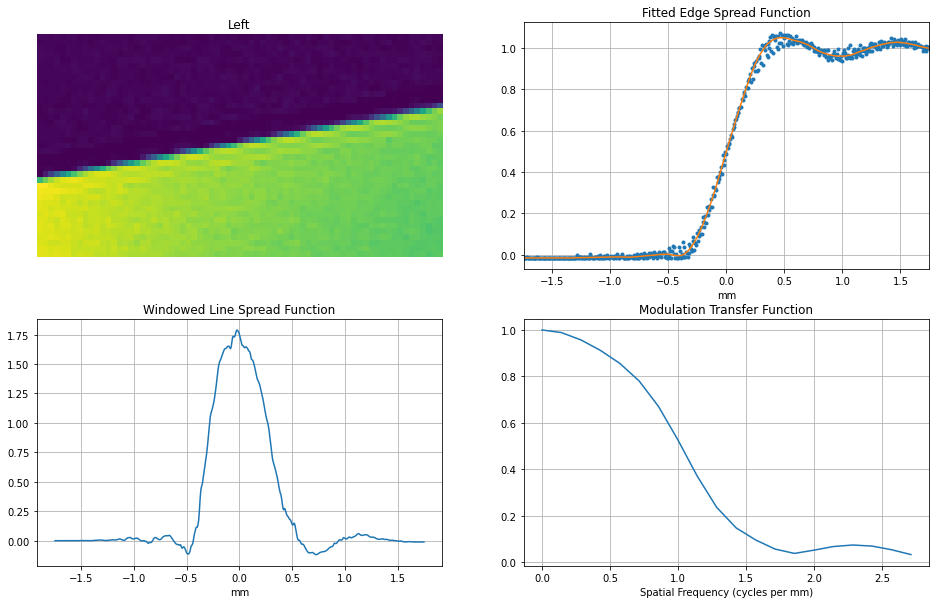

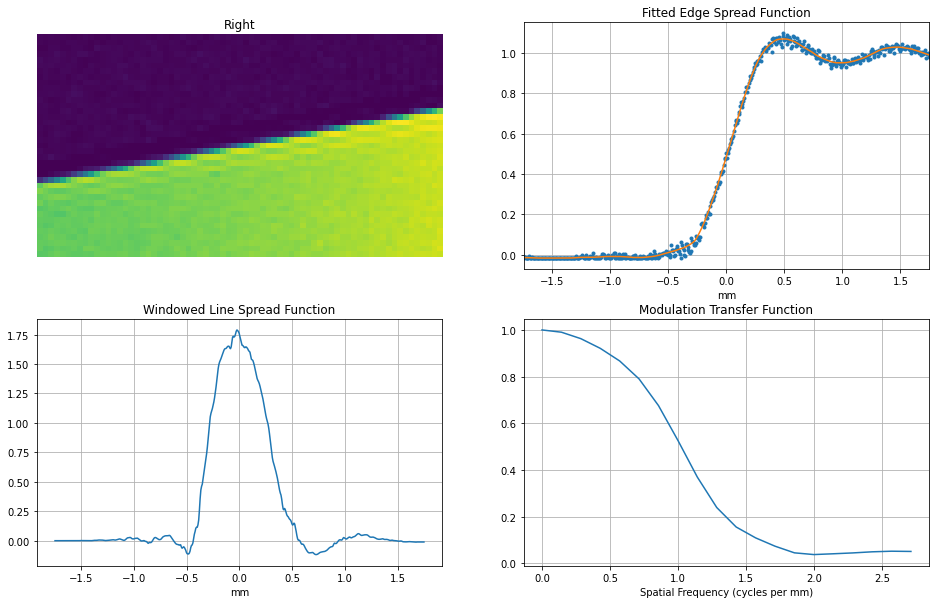

In [33]:
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Top'], 'Top')
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Bottom'], 'Bottom')
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Left'], 'Left')
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Right'], 'Right')

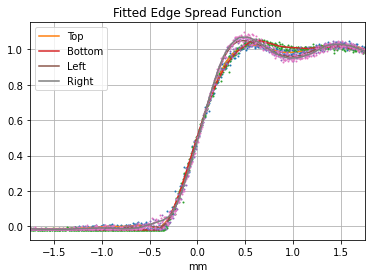

In [34]:
def plot_edge_responses(rois):
    fig, ax = plt.subplots()
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(roi, model=model)
        ax.plot(x_mm, esf, '.', markersize=2)
        ax.plot(x_mm_grid, esf_grid, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        ax.grid(True)
        ax.set_xlabel('mm')
        ax.set_title('Fitted Edge Spread Function')
        ax.legend()

plot_edge_responses(subrois)

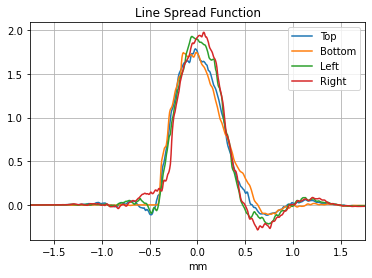

In [35]:
def plot_line_responses(rois):
    fig, ax = plt.subplots()
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(roi, model=model)
        ax.plot(x_mm_grid, lsf, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        ax.grid(True)
        ax.set_xlabel('mm')
        ax.set_title('Line Spread Function')
        ax.legend()

plot_line_responses(subrois)

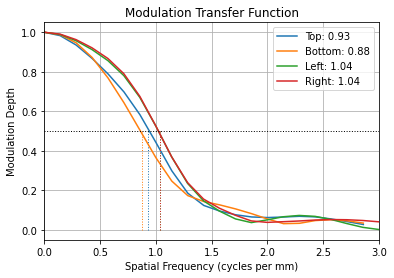

In [36]:
def plot_mtfs(rois, cutoff=3.0):
    def _find_index(x, value):
        return np.diff(np.sign(x - value)).nonzero()[0][0]    
    def _half_max(x, y):
        x_interp = np.linspace(x[0], x[-1], 50)
        y_interp = interp1d(x, y)(x_interp)
        return x_interp[(abs(y_interp - 0.5)).argmin()] 

    fig, ax = plt.subplots()
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(roi, model=model)
        cutoff_index = _find_index(x_mtf, cutoff)
        x_mtf, mtf = x_mtf[:cutoff_index+1], mtf[:cutoff_index+1]
        halfmax = _half_max(x_mtf, mtf)

        p = ax.plot(x_mtf, mtf, label='%s: %0.2f' % (name, halfmax))
        ax.vlines(halfmax, 0, 0.5, color=p[0].get_color(), linewidth=1, linestyle='dotted')


    ax.set_xlim(0, cutoff)
    ax.grid(True)
    ax.set_xlabel('Spatial Frequency (cycles per mm)')
    ax.set_ylabel('Modulation Depth')
    ax.set_title('Modulation Transfer Function')
    ax.legend()
    ax.axhline(0.5, linewidth=1, color='black', linestyle='dotted')

plot_mtfs(subrois)

In [37]:
import pandas as pd

def report_edge_rois(rois, cutoff=3.0):

    def _find_index(x, value):
        return np.diff(np.sign(x - value)).nonzero()[0][0] 

    def _half_max(x, y):
        x_interp = np.linspace(x[0], x[-1], 50)
        y_interp = interp1d(x, y)(x_interp)
        return x_interp[(abs(y_interp - 0.5)).argmin()]
    
    halfmaxes = []
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(roi, model=model)
        cutoff_index = _find_index(x_mtf, cutoff)
        x_mtf, mtf = x_mtf[:cutoff_index+1], mtf[:cutoff_index+1]       
        halfmax = _half_max(x_mtf, mtf)
        halfmaxes.append(halfmax)

        ax = axs[0]
        ax.plot(x_mm, esf, '.', markersize=2)
        ax.plot(x_mm_grid, esf_grid, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        
        ax = axs[1]
        ax.plot(x_mm_grid, lsf, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])

        ax = axs[2]
        p = ax.plot(x_mtf, mtf, label='%s: %0.2f' % (name, halfmax))
        ax.vlines(halfmax, 0, 0.5, color=p[0].get_color(), linewidth=1, linestyle='dotted')

    ax = axs[0]
    ax.grid(True)
    ax.set_xlabel('Distance from Edge (mm)')
    ax.set_ylabel('Normalised Brightness')
    ax.set_title('Fitted Edge Spread Function')
    ax.legend()
    
    ax = axs[1]
    ax.grid(True)
    ax.set_xlabel('Distance from Edge (mm)')
    ax.set_title('Line Spread Function (Windowed)')
    ax.legend()
    
    ax = axs[2]
    ax.set_xlim(0, cutoff)
    ax.grid(True)
    ax.set_xlabel('Spatial Frequency (cycles per mm)')
    ax.set_ylabel('Modulation Depth')
    ax.set_title('Modulation Transfer Function')
    ax.axhline(0.5, linewidth=1, color='black', linestyle='dotted')
    ax.legend()
    
    # need to add code to calculate FWHM of line response and similar from MTF

    return pd.DataFrame({'MTF_HalfMax': halfmaxes}, index=rois.keys())


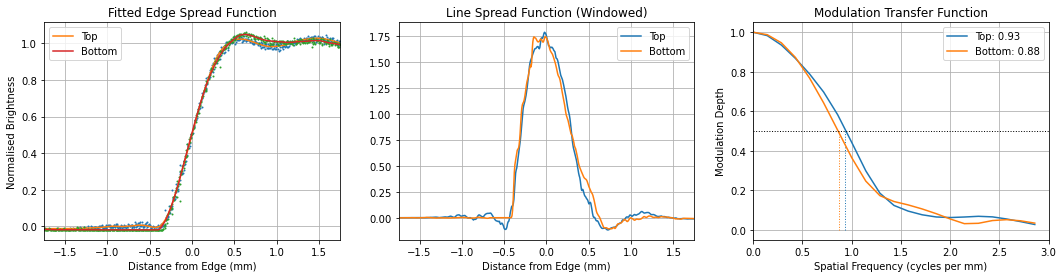

MTF_HalfMax
Top        0.933785
Bottom     0.875256

In [38]:
x = report_edge_rois({k: subroi for (k, subroi) in subrois.items() if k in {'Top', 'Bottom'}})
plt.show()
x

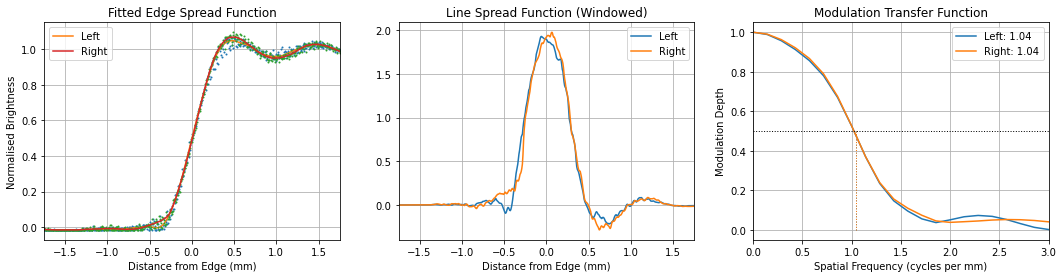

MTF_HalfMax
Left      1.040404
Right     1.040037

In [39]:
x = report_edge_rois({k: subroi for (k, subroi) in subrois.items() if k in {'Left', 'Right'}})
plt.show()
x

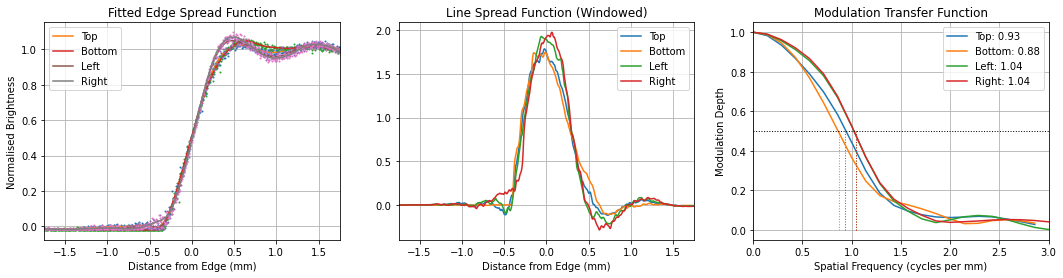

MTF_HalfMax
Top        0.933785
Bottom     0.875256
Left       1.040404
Right      1.040037

In [40]:
x = report_edge_rois(subrois)
plt.show()
x

- Maybe we should do vertical distance for the horizontal edges??
- Check roi code for dependencies on which edge

- Using PSN or applying a gain field  after the event will make the top of the curve tighter *but* it will also do something to the noise and so disort the bottom if the graph.
- it looks like the bottom edge gets clipped to zero - is this real or have we clipped somewhere rather than rounded.

----

### TO4

In [41]:
from mriqa.phantoms import TO4
from mriqa.dcmio import pix_spacing_yx
from mriqa.tools import find_phantom
patid = 'PQA20140807SC'
stuid = '3'
sernos = [85]
dobj = fetch_series(patid, stuid, sernos)[0]

mtf_image = all_ims([dobj])[0]
mtf_image = np.fliplr(mtf_image)
pix_dims = pix_spacing_yx(dobj)

# assume square pixels
assert np.isclose(*pix_dims)

expected_radius = TO4['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(mtf_image, expected_radius=expected_radius)
print(centre_x, centre_y, radius)

#x = piqt_mtf_report(dobjs[0], dobjs[0], mtf_phantom=TO4, centring_phantom=TO4)

501 513 386


(1.3777747442650152, -0.1797097492519585, 1.3777747442650152, -0.1797097492519585) (40.0, 0.0, 204.0, 165.0)
line1: 78.9406779661017 40.0
line2: -10.296610169491526 0.0
line3: 78.9406779661017 204.0
line4: -10.296610169491526 165.0
Intersections: [ 7.15039371 39.35931187] [169.10054425   7.70534349]
centre: [88.12546898 23.53232768]
165.01462048418762


/tmp/ipykernel_22269/3254487190.py:153: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  axs[2].imshow(subroi)


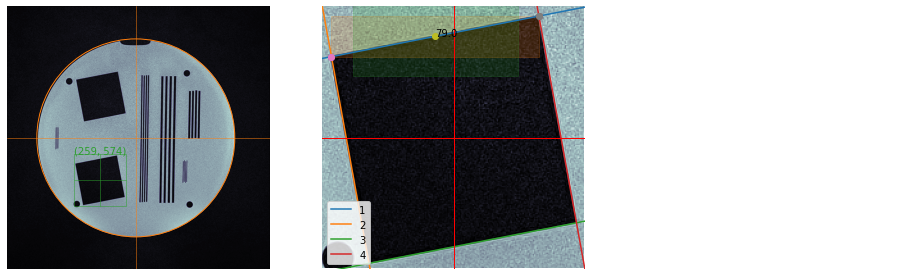

In [42]:
TO4 = {
    'Name': 'TO4',
    'Diameter': 188,  # mm
    'PD': 1.0,
    'T1': 500.0,
    'T2': 500.0,
    'Features': {
        'Holes': [
            (( 48, -62), (6, 6)),
            ((-65, -54), (6, 6)),
            ((-56,  63), (6, 6)),
            (( 52,  63), (6, 6))
        ],
        'Blocks': [
            ((-60, -67), (55, 55)),
            ((-59,  15), (50, 50))
        ],
        'Bars': [
            ((-79, -12), ( 7,  24)),  # 0.3 mm
            (( 42,  19), (10,  26)),  # 0.5 mm
            ((  0, -62), (16, 126)),  # 1.0 mm
            (( 46, -48), (18,  52)),  # 1.5 mm
            (( 20, -62), (20, 126))   # 2.0 mm
        ]
    },
    'FeatureSizes': {
        'Bars': [0.3, 0.5, 1.0, 1.5, 2.0]
    }
}

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(mtf_image, cmap='bone')
axs[0].axis('off')
axs[0].grid(False)
nrows, ncols = mtf_image.shape

axs[0].axvline(centre_x, linewidth=0.5, color='C1')
axs[0].axhline(centre_y, linewidth=0.5, color='C1')
axs[0].add_artist(
    plt.Circle((centre_x, centre_y), radius, color='C1', fill=False)
)

phantom = TO4
blocks = phantom['Features']['Blocks']

(x, y), (dx, dy) = np.array(blocks[1]) / pix_dims
# are we missing an off-by-one adjustment here?
x += centre_x
y += centre_y

x = int(round(x))
y = int(round(y))
dx = int(round(dx))
dy = int(round(dy))

axs[0].text(x, y, f'({x}, {y})', color='C2')
axs[0].add_artist(
    plt.Rectangle((x, y), dx, dy, color='C2', fill=False, linewidth=0.5)
)
axs[0].vlines([x+dx/2], y, y+dy, color='C2', linewidth=0.5)
axs[0].hlines([y+dy/2], x, x+dx, color='C2', linewidth=0.5)

roi = mtf_image[y:y+dy, x:x+dx]

axs[1].imshow(roi, cmap='bone')
axs[1].axis('off')
axs[1].grid(False)
nrows, ncols = roi.shape

axs[1].axvline(ncols/2, linewidth=0.5, color='C1')
axs[1].axhline(nrows/2, linewidth=0.5, color='C1')

x0_x1 = np.array([0, roi.shape[1]])
angles, dists = get_mtf_edges(roi)
print(angles, dists)


for i, (angle, dist) in enumerate(zip(angles, dists)):
    y0_y1 = (dist - x0_x1 * np.cos(angle)) / np.sin(angle)
    axs[1].plot(x0_x1, y0_y1, label=f'{i+1}')

axs[1].legend()
axs[1].set_xlim(x0_x1)
axs[1].set_ylim((roi.shape[0], 0))
axs[1].axis(False)
axs[1].axhline(roi.shape[0]/2, color='red', linewidth=1)
axs[1].axvline(roi.shape[1]/2, color='red', linewidth=1)

line1 = angles[0], dists[0]
line2 = angles[1], dists[1]
line3 = angles[2], dists[2]
line4 = angles[3], dists[3]

print('line1:', np.degrees(angles[0]), dists[0])
print('line2:', np.degrees(angles[1]), dists[1])
print('line3:', np.degrees(angles[2]), dists[2])
print('line4:', np.degrees(angles[3]), dists[3])

axs[1].plot(*intersection(line1, line2), 'o')
axs[1].plot(*intersection(line1, line4), 'o')

p1 = np.array(intersection(line1, line2))
p2 = np.array(intersection(line1, line4))
# centre of line segment
p0 = (p2 + p1) / 2

print('Intersections:', p1, p2)
print('centre:', p0)
        
axs[1].plot(*p1, 'o')
axs[1].plot(*p2, 'o')
axs[1].plot(*p0, 'o')
axs[1].text(*p0, np.round(np.degrees(angles[0])))
line_segment_length = np.hypot(*(p1 - p2))
print(line_segment_length)

ps = np.array([p1, p2])

bbox = np.asarray([
    np.min(ps, axis=0),
    np.max(ps, axis=0)
])
axs[1].add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='C1'
    )
)  

# this will depend on pixel size - we needsomething phantom related
# this seems to be not quite central - correct for angle?
bbox[0] -= (-line_segment_length/10, 15)
bbox[1] += (-line_segment_length/10, 15)

axs[1].add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='C2'
    )
)
bbox = np.round(bbox).astype(int)


subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
axs[2].imshow(subroi)
axs[2].axis(False);


All lines: [(1.3777747442650152, 40.0), (-0.1797097492519585, 0.0), (1.3777747442650152, 204.0), (-0.1797097492519585, 165.0)]
Horizontal lines: [(1.3777747442650152, 40.0), (1.3777747442650152, 204.0)]
Vertical lines: [(-0.1797097492519585, 0.0), (-0.1797097492519585, 165.0)]
165.01462048418762
Horiz BBox: box=[[  7.15039371   7.70534349]
 [169.10054425  39.35931187]], height=31.653968380208624, width=161.95015053813697
Line Segment Length: 165.01462048418762
Horiz BBox (Adjusted): box=[[ 23.65185576  -7.29465651]
 [152.5990822   54.35931187]], height=61.653968380208624, width=128.94722644129945
Horiz BBox (Rounded): box=[[ 24  -7]
 [153  54]], height=61, width=129
Horiz BBox (Clipped): box=[[ 24   0]
 [153  54]], height=54, width=129
Subroi shape: (54, 129)
Profile length: 54
165.01462048418765
Horiz BBox: box=[[ 36.46700794 169.07852217]
 [198.41715848 200.73249055]], height=31.653968380208596, width=161.950150538137
Line Segment Length: 165.01462048418762
Horiz BBox (Adjusted): box

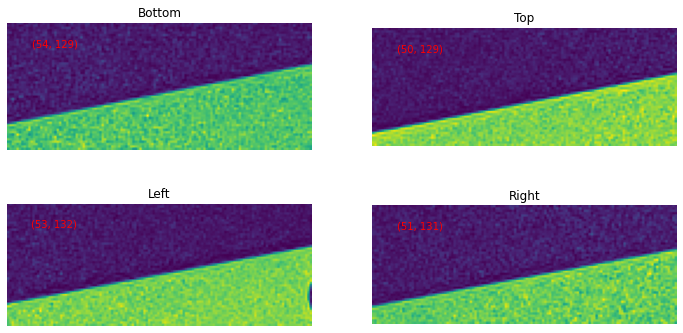

In [43]:
subrois = get_subrois(roi, angles, dists)

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for ax, (name, subroi) in zip(axs.flat, subrois.items()):
    ax.imshow(subroi)
    ax.set_title(name)
    ax.text(10, 10, f'{subroi.shape}', color='r')
    ax.axis('off')

/tmp/ipykernel_22269/2095582086.py:123: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_22269/2095582086.py:123: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_22269/2095582086.py:123: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_22269/2095582086.py:123: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


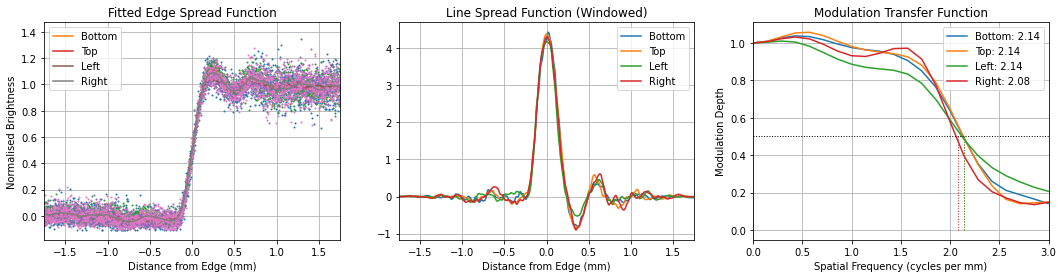

MTF_HalfMax
Bottom     2.138720
Top        2.138984
Left       2.140418
Right      2.080059

In [44]:
x = report_edge_rois(subrois)
plt.show()
x